In [20]:
!git clone https://github.com/joestubbs/coe379L-sp25.git

Cloning into 'coe379L-sp25'...
remote: Enumerating objects: 22096, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 22096 (delta 120), reused 150 (delta 60), pack-reused 21878 (from 4)
Receiving objects: 100% (22096/22096), 247.06 MiB | 76.18 MiB/s, done.
Resolving deltas: 100% (420/420), done.
Updating files: 100% (21476/21476), done.


In [42]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import random
import shutil
from pathlib import Path

import keras
from keras import layers
from keras import optimizers
from keras import models

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

## Part 1

a) Write code to load the data into Python data structures

Damaged images: 14170
Non-damaged images: 7152
10 Damaged Samples:


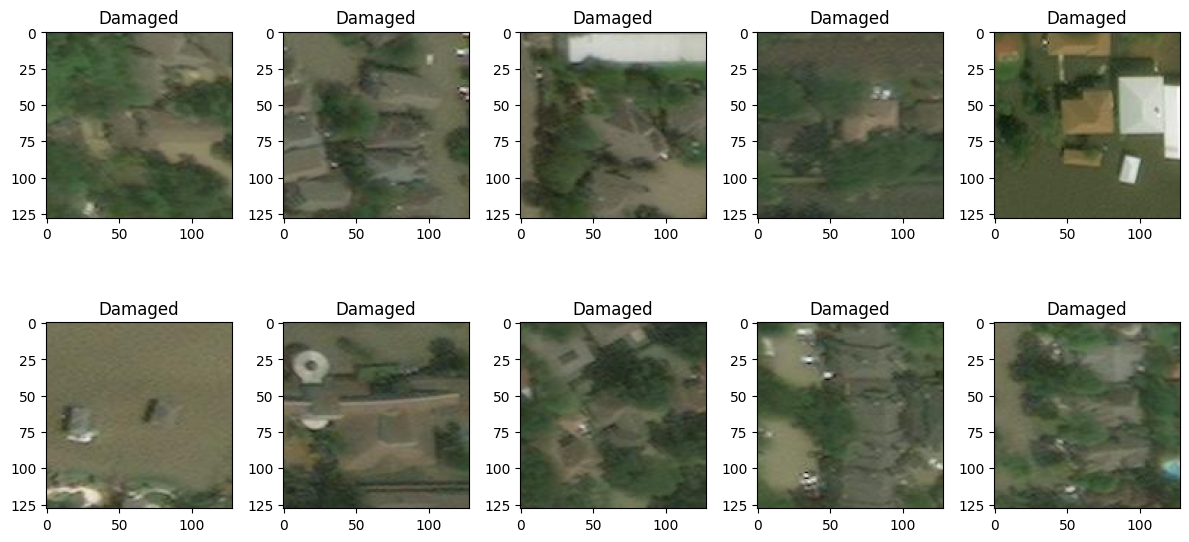

10 Non-Damaged Samples:


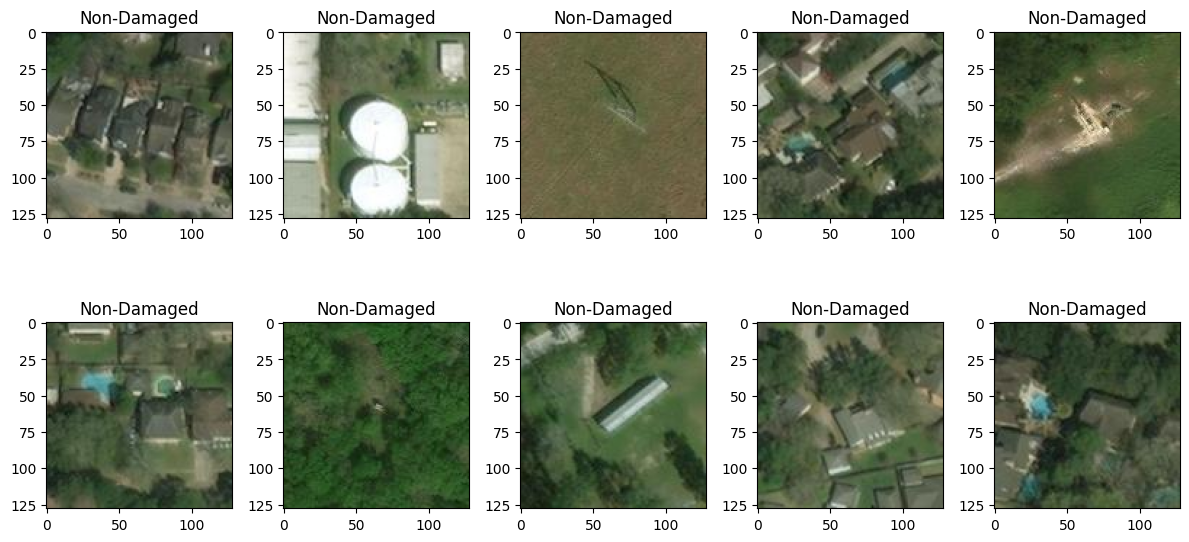

In [45]:
damaged_dir =  "old/coe379L-sp25/datasets/unit03/Project3/damage"
nondamaged_dir = "old/coe379L-sp25/datasets/unit03/Project3/no_damage"

damaged_files = os.listdir(damaged_dir)
nondamaged_files = os.listdir(nondamaged_dir)

print(f"Damaged images: {len(damaged_files)}")
print(f"Non-damaged images: {len(nondamaged_files)}")

print("10 Damaged Samples:")
samples = random.sample(damaged_files, 10)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i, filename in enumerate(samples):
    img = Image.open(os.path.join(damaged_dir, filename))
    axes[i].imshow(img)
    axes[i].set_title("Damaged")

plt.tight_layout()
plt.show()

print("10 Non-Damaged Samples:")
samples = random.sample(nondamaged_files, 10)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i, filename in enumerate(samples):
    img = Image.open(os.path.join(nondamaged_dir, filename))
    axes[i].imshow(img)
    axes[i].set_title("Non-Damaged")


plt.tight_layout()
plt.show()

b) Investigate the datasets to determine basic attributes of the images

First, I inspected our dataset by loading 10 random images from the damaged and not damages labels. This allowed me to visually see the differences between damaged and not damaged buildings. I also investigated the size of the images, and they all were had 128x128 dimensions. Additionally, the images were all of type RGB, which will also be important in processing later. 

In [49]:
damaged_dir =  "old/coe379L-sp25/datasets/unit03/Project3/damage"
nondamaged_dir = "old/coe379L-sp25/datasets/unit03/Project3/no_damage"
damaged_files = os.listdir(damaged_dir)
nondamaged_files = os.listdir(nondamaged_dir)

samples = random.sample(damaged_files, 3)
for i, filename in enumerate(samples):
    img = Image.open(os.path.join(damaged_dir, filename))
    size = img.size
    print("Image size: ", size)
    print("Image mode: ", mode)
    print()

samples = random.sample(nondamaged_files, 3)
for i, filename in enumerate(samples):
    img = Image.open(os.path.join(damaged_dir, filename))
    size = img.size
    mode = img.mode
    print("Image size: ", size)
    print("Image mode: ", mode)
    print()

Image size:  (128, 128)
Image mode:  RGB

Image size:  (128, 128)
Image mode:  RGB

Image size:  (128, 128)
Image mode:  RGB

Image size:  (128, 128)
Image mode:  RGB

Image size:  (128, 128)
Image mode:  RGB

Image size:  (128, 128)
Image mode:  RGB



## Pre Processing Data

c) Ensure data is split for training, validation and testing and perform any additional preprocessing (e.g., rescaling, normalization, etc.) so that it can be used for training/evaluation of the neural networks you will build in Part 2.

I chose to do an 80% training data, 20% testing data split. I chose a random sample of 80% of damaged images and 80% of non damaged images to create my training data set. I separated them into their own folders in my directory and ensured there was no overlap.  

In [50]:
for sets in ["train", "test"]:
    for label in ["damage", "no_damage"]:
        Path(f"Data/{sets}/{label}").mkdir(parents=True, exist_ok=True)

In [51]:
damaged_dir =  "old/coe379L-sp25/datasets/unit03/Project3/damage"
nondamaged_dir = "old/coe379L-sp25/datasets/unit03/Project3/no_damage"

trd = "Data/train/damage"
ted = "Data/test/damage"
trnd = "Data/train/no_damage"
tend = "Data/test/no_damage"

damaged_imgs = os.listdir(damaged_dir)
nondamaged_imgs = os.listdir(nondamaged_dir)

# We want to create an 80-20 training split 
eighty = int(0.8 * len(damaged_imgs))
eightynon = int(0.8 * len(nondamaged_imgs))

train_damage = random.sample(damaged_imgs, eighty)
test_damage = list(set(damaged_imgs) - set(train_damage))

train_nodamage = random.sample(nondamaged_imgs, eightynon)
test_nodamage = list(set(nondamaged_imgs) - set(train_nodamage))

def copy_images(file_list, src_folder, dest_folder):
    for fname in file_list:
        shutil.copy2(os.path.join(src_folder, fname), os.path.join(dest_folder, fname))

copy_images(train_damage, damaged_dir, trd)
copy_images(test_damage, damaged_dir, ted)

copy_images(train_nodamage, nondamaged_dir, trnd)
copy_images(test_nodamage, nondamaged_dir, tend)

In [52]:
damaged_dir =  "old/coe379L-sp25/datasets/unit03/Project3/damage"
nondamaged_dir = "old/coe379L-sp25/datasets/unit03/Project3/no_damage"

damaged_files = os.listdir(damaged_dir)
nondamaged_files = os.listdir(nondamaged_dir)

print(f"Damaged images: {len(damaged_files)}")
print(f"Non-damaged images: {len(nondamaged_files)}")


Damaged images: 14170
Non-damaged images: 7152


In [53]:
tr_damaged_dir =  "Data/train/damage"
tr_nodamaged_dir =  "Data/train/no_damage"

te_damaged_dir =  "Data/test/damage"
te_nodamaged_dir =  "Data/test/no_damage"

tr_damaged_files = os.listdir(tr_damaged_dir)
tr_nodamaged_files = os.listdir(tr_nodamaged_dir)
te_damaged_files = os.listdir(te_damaged_dir)
te_nodamaged_files = os.listdir(te_nodamaged_dir)


print(f"Damaged Training images: {len(tr_damaged_files)}")
print(f"Non-damaged Training images: {len(tr_nodamaged_files)}")
print(f"Damaged Testing images: {len(te_damaged_files)}")
print(f"Non-damaged Testing images: {len(te_nodamaged_files)}")

Damaged Training images: 13612
Non-damaged Training images: 6832
Damaged Testing images: 5111
Non-damaged Testing images: 2542


In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Image_Size = (128,128)
Batch_Size = 32

train_dir = 'Data/train'
test_dir = 'Data/test'

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=Image_Size,
    batch_size=Batch_Size
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=Image_Size,
    batch_size=Batch_Size
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=Image_Size,
)

normalize = Rescaling(1.0 / 255)
train_dataset = train_dataset.map(lambda x, y: (normalize(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalize(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalize(x), y))

Found 20444 files belonging to 2 classes.
Using 16356 files for training.
Found 20444 files belonging to 2 classes.
Using 4088 files for validation.
Found 7653 files belonging to 2 classes.


I prepared the images through Tensorflow's helper functions to load all of the images. The code loads the training and validation images, and resizes all the images to 128x128 size and normalizes them through rescaling. This prepares us adequately to begin training our models. 

## Part 2 - Model Training
You will explore different model architectures that we have seen in class, including:
- A dense (i.e., fully connected) ANN
- The Lenet-5 CNN architecture
- Alternate-Lenet-5 CNN architecture, described in the following paper https://arxiv.org/pdf/1807.01688.pdf



### Basic ANN

In [14]:
annmodel = models.Sequential()

annmodel.add(layers.Flatten(input_shape=(128, 128, 3)))
annmodel.add(layers.Dense(128, activation='relu'))
annmodel.add(layers.Dense(64, activation='relu'))
annmodel.add(layers.Dense(2, activation='softmax'))
annmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
annmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 49152)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               6291584   
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 6299970 (24.03 MB)
Trainable params: 6299970 (24.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
annmodel.fit(train_dataset,batch_size=32,epochs=20,validation_data=val_dataset)

Epoch 1/20
427/427 [==============================] - 12s 26ms/step - loss: 0.9013 - accuracy: 0.6339 - val_loss: 0.6287 - val_accuracy: 0.6799
Epoch 2/20
427/427 [==============================] - 11s 26ms/step - loss: 0.5881 - accuracy: 0.7034 - val_loss: 0.5530 - val_accuracy: 0.7408
Epoch 3/20
427/427 [==============================] - 11s 26ms/step - loss: 0.5906 - accuracy: 0.7040 - val_loss: 0.5262 - val_accuracy: 0.7520
Epoch 4/20
427/427 [==============================] - 11s 26ms/step - loss: 0.5521 - accuracy: 0.7323 - val_loss: 0.5661 - val_accuracy: 0.7288
Epoch 5/20
427/427 [==============================] - 11s 26ms/step - loss: 0.5597 - accuracy: 0.7242 - val_loss: 0.5374 - val_accuracy: 0.7532
Epoch 6/20
427/427 [==============================] - 11s 26ms/step - loss: 0.5453 - accuracy: 0.7415 - val_loss: 0.6160 - val_accuracy: 0.6910
Epoch 7/20
427/427 [==============================] - 11s 26ms/step - loss: 0.5348 - accuracy: 0.7512 - val_loss: 0.5215 - val_accuracy:

In [16]:
test_loss, test_accuracy = annmodel.evaluate(test_dataset, verbose=0)
test_accuracy

0.7889800667762756

### LeNet-5 Model

In [20]:
lenet = models.Sequential()

lenet.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(128, 128, 3)))
lenet.add(layers.AveragePooling2D((2, 2)))
             
lenet.add(layers.Conv2D(16, (5, 5), activation='relu'))
lenet.add(layers.AveragePooling2D((2, 2)))
             
lenet.add(layers.Flatten())

lenet.add(layers.Dense(120, activation='relu'))
lenet.add(layers.Dense(84, activation='relu'))

lenet.add(layers.Dense(2, activation='softmax'))
lenet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lenet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d_2 (Avera  (None, 62, 62, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_7 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_3 (Avera  (None, 29, 29, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_3 (Flatten)         (None, 13456)             0         
                                                                 
 dense_8 (Dense)             (None, 120)              

In [21]:
lenet.fit(train_dataset,batch_size=32,epochs=20,validation_data=val_dataset)

Epoch 1/20
427/427 [==============================] - 44s 100ms/step - loss: 0.3892 - accuracy: 0.8327 - val_loss: 0.2608 - val_accuracy: 0.8942
Epoch 2/20
427/427 [==============================] - 42s 99ms/step - loss: 0.2266 - accuracy: 0.9132 - val_loss: 0.2325 - val_accuracy: 0.9079
Epoch 3/20
427/427 [==============================] - 42s 99ms/step - loss: 0.1838 - accuracy: 0.9269 - val_loss: 0.1970 - val_accuracy: 0.9220
Epoch 4/20
427/427 [==============================] - 42s 99ms/step - loss: 0.1485 - accuracy: 0.9434 - val_loss: 0.2241 - val_accuracy: 0.9082
Epoch 5/20
427/427 [==============================] - 42s 98ms/step - loss: 0.0981 - accuracy: 0.9624 - val_loss: 0.1818 - val_accuracy: 0.9346
Epoch 6/20
427/427 [==============================] - 41s 97ms/step - loss: 0.0909 - accuracy: 0.9660 - val_loss: 0.1892 - val_accuracy: 0.9288
Epoch 7/20
427/427 [==============================] - 41s 97ms/step - loss: 0.0617 - accuracy: 0.9782 - val_loss: 0.2599 - val_accuracy

In [22]:
test_loss, test_accuracy = lenet.evaluate(test_dataset, verbose=0)
test_accuracy

0.9317702054977417

### Alternate LeNet-5 Model

Based off of https://arxiv.org/pdf/1807.01688 -- Page 12 Table 1

In [32]:
lenet_new = models.Sequential()

lenet_new.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
lenet_new.add(layers.MaxPooling2D((2, 2)))

lenet_new.add(layers.Conv2D(64, (3, 3), activation='relu')) 
lenet_new.add(layers.MaxPooling2D((2, 2)))

lenet_new.add(layers.Conv2D(128, (3, 3), activation='relu')) 
lenet_new.add(layers.MaxPooling2D((2, 2)))

lenet_new.add(layers.Conv2D(128, (3, 3), activation='relu')) 
lenet_new.add(layers.MaxPooling2D((2, 2)))
             
lenet_new.add(layers.Flatten())
lenet_new.add(layers.Dropout(0.5))

lenet_new.add(layers.Dense(512, activation='relu'))
#lenet_new.add(layers.Dense(1, activation='sigmoid'))
lenet_new.add(layers.Dense(2, activation='softmax'))


lenet_new.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lenet_new.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 14, 14, 128)      

In [33]:
lenet_new.fit(train_dataset,batch_size=32,epochs=20,validation_data=val_dataset)

Epoch 1/20
427/427 [==============================] - 89s 206ms/step - loss: 0.3269 - accuracy: 0.8591 - val_loss: 0.2115 - val_accuracy: 0.9173
Epoch 2/20
427/427 [==============================] - 89s 209ms/step - loss: 0.1612 - accuracy: 0.9379 - val_loss: 0.1304 - val_accuracy: 0.9452
Epoch 3/20
427/427 [==============================] - 89s 209ms/step - loss: 0.1389 - accuracy: 0.9472 - val_loss: 0.1262 - val_accuracy: 0.9513
Epoch 4/20
427/427 [==============================] - 90s 211ms/step - loss: 0.1151 - accuracy: 0.9563 - val_loss: 0.1066 - val_accuracy: 0.9604
Epoch 5/20
427/427 [==============================] - 89s 208ms/step - loss: 0.1023 - accuracy: 0.9613 - val_loss: 0.1065 - val_accuracy: 0.9610
Epoch 6/20
427/427 [==============================] - 88s 207ms/step - loss: 0.0929 - accuracy: 0.9639 - val_loss: 0.1069 - val_accuracy: 0.9592
Epoch 7/20
427/427 [==============================] - 89s 209ms/step - loss: 0.0888 - accuracy: 0.9668 - val_loss: 0.1774 - val_ac

In [34]:
test_loss, test_accuracy = lenet_new.evaluate(test_dataset, verbose=0)
test_accuracy

0.9807737469673157

In [31]:
lenet_new.save("best_model.keras")

In [36]:
lenet_new.save("best_model.h5")

/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
